In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
def initialstate(N):   
    ''' 
    Generates a random spin configuration for initial condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

In [3]:
def mcmove(config, beta, N =16):
    '''
    Monte Carlo move using Metropolis algorithm 
    '''
    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                
                if cost < 0:
                    s *= -1
                elif np.random.rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    
    return config



def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    return mag

In [4]:

nt      = 200        #  number of temperature points
N       = 16         #  size of the lattice, N x N
eqSteps = 2**8       #  number of MC sweeps for equilibration
mcSteps = 2**9       #  number of MC sweeps for calculation

T_c = 2.269
T       = np.linspace(0.1, 4, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)


In [5]:
T

array([0.1       , 0.11959799, 0.13919598, 0.15879397, 0.17839196,
       0.19798995, 0.21758794, 0.23718593, 0.25678392, 0.27638191,
       0.2959799 , 0.31557789, 0.33517588, 0.35477387, 0.37437186,
       0.39396985, 0.41356784, 0.43316583, 0.45276382, 0.47236181,
       0.4919598 , 0.51155779, 0.53115578, 0.55075377, 0.57035176,
       0.58994975, 0.60954774, 0.62914573, 0.64874372, 0.66834171,
       0.6879397 , 0.70753769, 0.72713568, 0.74673367, 0.76633166,
       0.78592965, 0.80552764, 0.82512563, 0.84472362, 0.86432161,
       0.8839196 , 0.90351759, 0.92311558, 0.94271357, 0.96231156,
       0.98190955, 1.00150754, 1.02110553, 1.04070352, 1.06030151,
       1.0798995 , 1.09949749, 1.11909548, 1.13869347, 1.15829146,
       1.17788945, 1.19748744, 1.21708543, 1.23668342, 1.25628141,
       1.2758794 , 1.29547739, 1.31507538, 1.33467337, 1.35427136,
       1.37386935, 1.39346734, 1.41306533, 1.43266332, 1.45226131,
       1.4718593 , 1.49145729, 1.51105528, 1.53065327, 1.55025

This method generates a configuration data using monte carlo simulation for 200 temperature points and 256 configurations per temperature value.  Each configuration is converted to a 1d array from 2d array and the temperature value of the configuration is added as a 1d array. This array of configuration data and temperature is converted to a dataframe. This method also calculates the magnetisation of the configuration and returns the dataframe and magnetisation.

In [6]:
def generate_ising_data(lattice_size):
    X = [] # input or independent feature
    n1, n2  = 1.0/(mcSteps*lattice_size*lattice_size), 1.0/(mcSteps*mcSteps*lattice_size*lattice_size) 
    
    for tt in range(nt):
        config = initialstate(lattice_size) 

        # initialise
        E1 = M1 = E2 = M2 = 0
        iT=1.0/T[tt]
        iT2=iT*iT
        
        #calculating magnetisation
        for i in range(mcSteps):
            mcmove(config, iT, lattice_size)           
                 
            Mag = calcMag(config)        # calculate the magnetisation  
            M1 = M1 + Mag
            
        # divide by number of sites and iteractions to obtain intensive values    
        
        M[tt] = n1*M1
        
        #generating the data

        for i in range(eqSteps):
            # equilibrate 
            c = mcmove(config, iT, lattice_size) 

            #generating the input features for the neural network
            oneD_ising  = np.ravel(c)
            input_features = np.append(oneD_ising, T[tt])
            X.append(input_features)
    X = np.array(X)
            
    columns = [f'L_{i}' for i in range(lattice_size*lattice_size)]
    columns = columns + ['Temperature']
            
    df = pd.DataFrame(data = X, columns = columns)
    return df, M

This method is created to return 1 if the temperature value of the configuration is less than the critical value, other wise it returns 0. The method is then applied to the dataframe to include the column representing the magnetic phase.

In [7]:
def generate_label(temp):
    if temp < T_c:
        return 1 #ferromagnetic
    elif temp > T_c:
        return 0 #paramagnetic

This method creates the architecture of the neural network for any given lattice size. The network consists of 1 input layer, 2 hidden layers, a dropout layer and 1 output layer. The model uses a rectified linear unit as the activation function of the hidden layers and a sigmoid activation function for the output layer. Adaptive momentum is the optimization algorithm and binary cross entropy is used for calculating the loss in the model.

In [8]:
def build_model(N):
    model = Sequential([Dense(128, activation = 'relu', input_shape = ((N*N)+1,)),
                      Dropout(0.15),
                      Dense(64, activation = 'relu'),
                      Dense(1, activation = 'sigmoid')])

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

Generating the configuration data for a 16 by 16 lattice.

In [10]:
train_data_16, _ = generate_ising_data(16)
train_data_16['Phase'] = train_data_16['Temperature'].apply(generate_label)
train_data_16.head()

,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,...,L_248,L_249,L_250,L_251,L_252,L_253,L_254,L_255,Temperature,Phase
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1


splitting the dataset into independent and dependent features for the purpose of training

In [11]:
X_train_16 = train_data_16.iloc[:, :-1]
y_train_16 = train_data_16.iloc[:, -1]


building the model for the lattice size of 16 by 16 and training it on the dataset. The train data is splitted into a train set and a validation set. 

In [12]:
model_16 = build_model(16)
model_16.fit(X_train_16, y_train_16, epochs = 35, validation_split =0.2, 
             verbose = 1, batch_size = 128)

Epoch 1/35
320/320 [==============================] - 3s 9ms/step - loss: 0.1190 - accuracy: 0.9531 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0784 - accuracy: 0.9697 - val_loss: 6.0121e-04 - val_accuracy: 1.0000
Epoch 3/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0643 - accuracy: 0.9748 - val_loss: 2.7269e-04 - val_accuracy: 1.0000
Epoch 4/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0579 - accuracy: 0.9762 - val_loss: 1.5835e-04 - val_accuracy: 1.0000
Epoch 5/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0525 - accuracy: 0.9786 - val_loss: 1.2441e-04 - val_accuracy: 1.0000
Epoch 6/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0482 - accuracy: 0.9804 - val_loss: 6.1513e-05 - val_accuracy: 1.0000
Epoch 7/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0439 - accuracy: 0.9825 - val_loss: 4.7983e-05 - val

generating a test set for the lattice size of 16 by 16

In [13]:
test_data_16, M_16 = generate_ising_data(16)
test_data_16

,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,...,L_247,L_248,L_249,L_250,L_251,L_252,L_253,L_254,L_255,Temperature
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51195,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,4.0
51196,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,4.0
51197,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,4.0
51198,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,4.0


model making predictions on the test set. The predicted probabilities is then averaged fo each temperature value using a group by object of dataframe.

In [15]:
y_pred_16 = model_16.predict(test_data_16)
test_data_16['Probabilities'] = y_pred_16
prob_df_16 = test_data_16.groupby(['Temperature']).mean()[['Probabilities']]
prob_df_16

,Probabilities
Temperature,
0.100000,1.000000e+00
0.119598,1.000000e+00
0.139196,1.000000e+00
0.158794,1.000000e+00
0.178392,1.000000e+00
...,...
3.921608,9.653196e-09
3.941206,5.620534e-07
3.960804,3.098642e-08


generating train data for a 10 by 10 lattice size

In [16]:
train_data_10, _ = generate_ising_data(10)
train_data_10['Phase'] = train_data_10['Temperature'].apply(generate_label)
train_data_10.head()  

,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,...,L_92,L_93,L_94,L_95,L_96,L_97,L_98,L_99,Temperature,Phase
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1


splitting the dataset into an independent and dependent feature for the purpose of training
creating the model to train the lattice of size 10 by 10.
generating the test data for lattice size of 10 by 10

model making predictions on the test data and averaging the probabilities of each temperature

In [17]:
X_train_10 = train_data_10.iloc[:, :-1]
y_train_10 = train_data_10.iloc[:, -1]

model_10 = build_model(10)
model_10.fit(X_train_10, y_train_10, epochs = 35, validation_split =0.2,
             verbose = 1, batch_size = 128)

test_data_10, M_10 = generate_ising_data(10)

y_pred_10 = model_10.predict(test_data_10)
test_data_10['Probabilities'] = y_pred_10

prob_df_10 = test_data_10.groupby(['Temperature']).mean()[['Probabilities']]
prob_df_10

Epoch 1/35
320/320 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.9289 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/35
320/320 [==============================] - 1s 3ms/step - loss: 0.1023 - accuracy: 0.9578 - val_loss: 8.1461e-04 - val_accuracy: 1.0000
Epoch 3/35
320/320 [==============================] - 2s 5ms/step - loss: 0.0894 - accuracy: 0.9627 - val_loss: 3.8283e-04 - val_accuracy: 1.0000
Epoch 4/35
320/320 [==============================] - 1s 2ms/step - loss: 0.0804 - accuracy: 0.9660 - val_loss: 1.8715e-04 - val_accuracy: 1.0000
Epoch 5/35
320/320 [==============================] - 1s 3ms/step - loss: 0.0763 - accuracy: 0.9674 - val_loss: 1.6399e-04 - val_accuracy: 1.0000
Epoch 6/35
320/320 [==============================] - 2s 6ms/step - loss: 0.0651 - accuracy: 0.9729 - val_loss: 4.8131e-05 - val_accuracy: 1.0000
Epoch 7/35
320/320 [==============================] - 1s 4ms/step - loss: 0.0666 - accuracy: 0.9719 - val_loss: 4.2638e-05 - val

,Probabilities
Temperature,
0.100000,1.000000e+00
0.119598,1.000000e+00
0.139196,1.000000e+00
0.158794,1.000000e+00
0.178392,1.000000e+00
...,...
3.921608,3.048463e-13
3.941206,1.761791e-13
3.960804,5.971557e-13


generating then train data for a lattice of size 24 by 24

In [18]:
train_data_24, _ = generate_ising_data(24)
train_data_24['Phase'] = train_data_24['Temperature'].apply(generate_label)
train_data_24.head()  

,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,...,L_568,L_569,L_570,L_571,L_572,L_573,L_574,L_575,Temperature,Phase
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.1,1


splitting the dataset into an independent and dependent feature for the purpose of training
creating the model to train the lattice of size 24 by 24.
generating the test data for lattice size of 24 by 24

model making predictions on the test data and averaging the probabilities of each temperature

In [19]:
X_train_24 = train_data_24.iloc[:, :-1]
y_train_24 = train_data_24.iloc[:, -1]

model_24 = build_model(24)
model_24.fit(X_train_24, y_train_24, epochs = 35, validation_split =0.2,
             verbose = 1, batch_size = 128)

test_data_24, M_24 = generate_ising_data(24)

y_pred_24 = model_24.predict(test_data_24)
test_data_24['Probabilities'] = y_pred_24

prob_df_24 = test_data_24.groupby(['Temperature']).mean()[['Probabilities']]
prob_df_24

Epoch 1/35
320/320 [==============================] - 3s 11ms/step - loss: 0.0891 - accuracy: 0.9653 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/35
320/320 [==============================] - 3s 8ms/step - loss: 0.0397 - accuracy: 0.9860 - val_loss: 6.6863e-04 - val_accuracy: 1.0000
Epoch 3/35
320/320 [==============================] - 3s 9ms/step - loss: 0.0257 - accuracy: 0.9907 - val_loss: 2.5635e-04 - val_accuracy: 1.0000
Epoch 4/35
320/320 [==============================] - 3s 10ms/step - loss: 0.0183 - accuracy: 0.9933 - val_loss: 2.4706e-04 - val_accuracy: 1.0000
Epoch 5/35
320/320 [==============================] - 3s 10ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 1.1183e-04 - val_accuracy: 1.0000
Epoch 6/35
320/320 [==============================] - 3s 11ms/step - loss: 0.0173 - accuracy: 0.9937 - val_loss: 1.2254e-04 - val_accuracy: 1.0000
Epoch 7/35
320/320 [==============================] - 3s 10ms/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 5.2260e-04 

,Probabilities
Temperature,
0.100000,1.000000e+00
0.119598,1.000000e+00
0.139196,1.000000e+00
0.158794,9.712588e-01
0.178392,1.000000e+00
...,...
3.921608,3.166459e-07
3.941206,3.664765e-07
3.960804,9.085020e-07


A plot of magnetisation against temperature for different lattice size
A plot of the probabilities (mean) against temperature for different lattice size. The probability curve was made to be symmetrical by subtracting 1 from each probability and plotting the curve. This was done to obtain the critical temperature value.

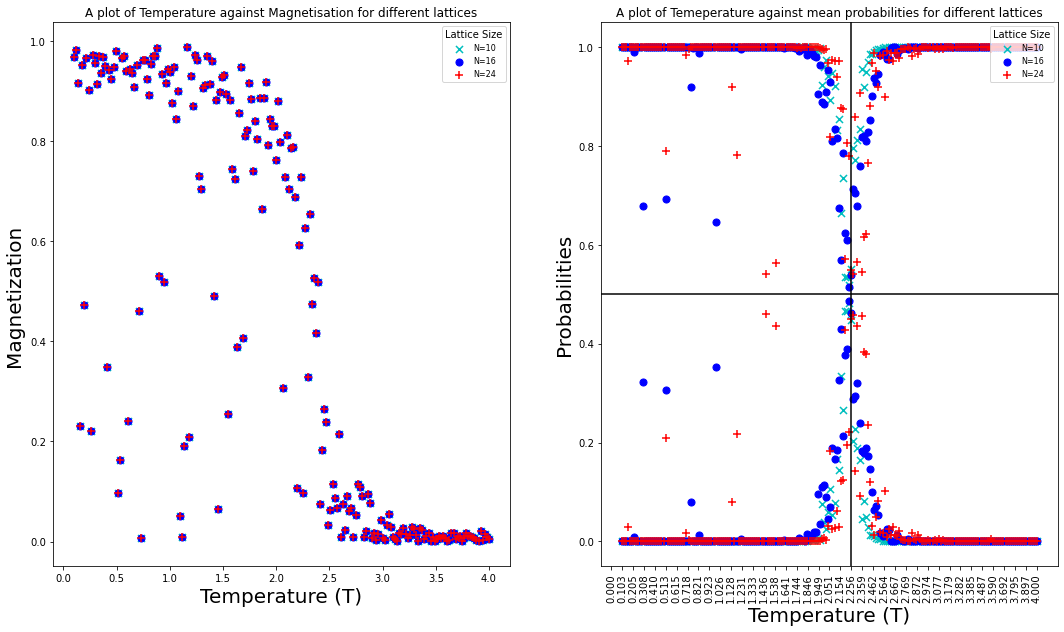

In [20]:
f = plt.figure(figsize=(18, 10)) #  

sp =  f.add_subplot(1, 2, 1 )
m_10 = plt.scatter(T, abs(M_10), marker = 'x', s = 50, c = 'c')
m_16 = plt.scatter(T, abs(M_16), marker = 'o', s = 50, c = 'b')
m_24 = plt.scatter(T, abs(M_24), marker = '+', s = 50, c = 'r')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Magnetization ", fontsize=20)  
plt.title('A plot of Temperature against Magnetisation for different lattices')
plt.axis('tight')
plt.legend((m_10, m_16, m_24),
           ('N=10', 'N=16', 'N=24'),
           loc='upper right',
           ncol=1,
           fontsize=8, 
          title ='Lattice Size')


sp =  f.add_subplot(1, 2, 2 )
N_10 = plt.scatter(prob_df_10.index,prob_df_10.Probabilities.values, marker = 'x', s = 50, c = 'c')
plt.scatter(prob_df_10.index,1 - prob_df_10.Probabilities.values, marker = 'x', s = 50, c = 'c')
N_16 = plt.scatter(prob_df_16.index,prob_df_16.Probabilities.values, marker = 'o', s = 50, c = 'b')
plt.scatter(prob_df_16.index,1 - prob_df_16.Probabilities.values, marker = 'o', s = 50, c = 'b')
N_24 = plt.scatter(prob_df_24.index,prob_df_24.Probabilities.values, marker = '+',s = 50, c = 'r')
plt.scatter(prob_df_24.index,1 - prob_df_24.Probabilities.values, marker = '+',s = 50, c = 'r')
plt.xlabel('Temperature (T)',  fontsize=20)
plt.ylabel('Probabilities',  fontsize=20)
plt.title('A plot of Temeperature against mean probabilities for different lattices')
plt.axhline(y=0.5, color='k', linestyle='-')
plt.axvline(x=2.25, color='k', linestyle='-')
plt.axis('tight')
plt.legend((N_10, N_16, N_24),
           ('N=10', 'N=16', 'N=24'),
           loc='upper right',
           ncol=1,
           fontsize=8, 
          title ='Lattice Size')
plt.xticks(np.linspace(0,4, 40), rotation = 'vertical')

plt.show() 

same graph as above just a smaller size

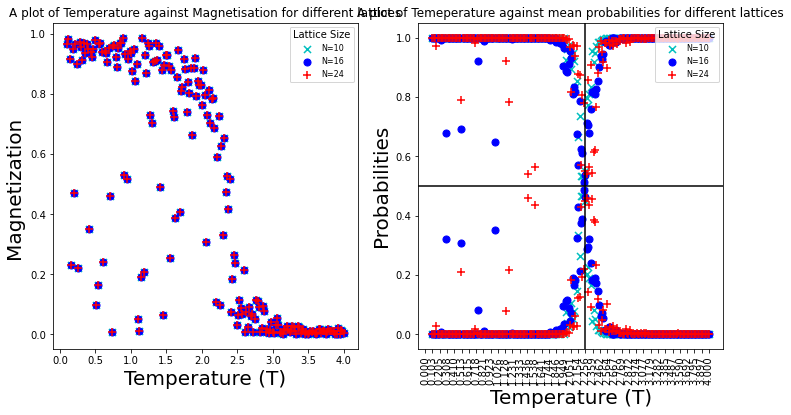

In [21]:
f = plt.figure(figsize=(12, 6)) #  

sp =  f.add_subplot(1, 2, 1 )
m_10 = plt.scatter(T, abs(M_10), marker = 'x', s = 50, c = 'c')
m_16 = plt.scatter(T, abs(M_16), marker = 'o', s = 50, c = 'b')
m_24 = plt.scatter(T, abs(M_24), marker = '+', s = 50, c = 'r')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Magnetization ", fontsize=20)  
plt.title('A plot of Temperature against Magnetisation')
plt.axis('tight')
plt.legend((m_10, m_16, m_24),
           ('N=10', 'N=16', 'N=24'),
           loc='upper right',
           ncol=1,
           fontsize=8, 
          title ='Lattice Size')


sp =  f.add_subplot(1, 2, 2 )
N_10 = plt.scatter(prob_df_10.index,prob_df_10.Probabilities.values, marker = 'x', s = 50, c = 'c')
plt.scatter(prob_df_10.index,1 - prob_df_10.Probabilities.values, marker = 'x', s = 50, c = 'c')
N_16 = plt.scatter(prob_df_16.index,prob_df_16.Probabilities.values, marker = 'o', s = 50, c = 'b')
plt.scatter(prob_df_16.index,1 - prob_df_16.Probabilities.values, marker = 'o', s = 50, c = 'b')
N_24 = plt.scatter(prob_df_24.index,prob_df_24.Probabilities.values, marker = '+',s = 50, c = 'r')
plt.scatter(prob_df_24.index,1 - prob_df_24.Probabilities.values, marker = '+',s = 50, c = 'r')
plt.xlabel('Temperature (T)',  fontsize=20)
plt.ylabel('Probabilities',  fontsize=20)
plt.title('A plot of Temeperature against mean probabilities ')
plt.axhline(y=0.5, color='k', linestyle='-')
plt.axvline(x=2.25, color='k', linestyle='-')
plt.axis('tight')
plt.legend((N_10, N_16, N_24),
           ('N=10', 'N=16', 'N=24'),
           loc='upper right',
           ncol=1,
           fontsize=8, 
          title ='Lattice Size')
plt.xticks(np.linspace(0,4, 40), rotation = 'vertical')

plt.show() 